<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Network

In [0]:
%tensorflow_version 2.0

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers as optim
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from IPython.display import clear_output
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)
%matplotlib inline

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of training examples: {len(train_images)} with shape: {train_images.shape}")
print(f"Number of testing examples: {len(test_images)} with shape: {test_images.shape}")

4423680/4422102 [==============================] - 0s 0us/step
Number of training examples: 60000 with shape: (60000, 28, 28)
Number of testing examples: 10000 with shape: (10000, 28, 28)


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) /127.5  

BUFFER_SIZE = 60000
BATCH_SIZE = 512

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Size of noise vector 
noise_dim = 128

In [0]:
img_shape = (28, 28, 1)

In [0]:
def conv_block(x,
                filters,
                activation, 
                kernel_size=(3,3),
                strides=(1,1),
                padding="same",
                use_bias=True,
                use_bn=False,
                use_dropout=False,
                drop_value=0.5):
    
    x = layers.Conv2D(filters, 
                      kernel_size, 
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

In [0]:
def get_discriminator_model():
    img_input = layers.Input(shape=img_shape)
    x = layers.ZeroPadding2D((2,2))(img_input)
    x = conv_block(x, 
                   64,
                   kernel_size=(5,5), 
                   strides=(2,2),
                   use_bn=False,
                   use_bias=False,
                   activation=layers.LeakyReLU(0.2),
                   use_dropout=False,
                   drop_value=0.3)
    x = conv_block(x, 
                   128,
                   kernel_size=(5,5),  
                   strides=(2,2),
                   use_bn=False,
                   activation=layers.LeakyReLU(0.2),
                   use_bias=True, 
                   use_dropout=True,
                   drop_value=0.3)
    x = conv_block(x, 
                   256,
                   kernel_size=(5,5),  
                   strides=(2,2),
                   use_bn=False,
                   activation=layers.LeakyReLU(0.2),
                   use_bias=True, 
                   use_dropout=True,
                   drop_value=0.3)
    x = conv_block(x, 
                   512,
                   kernel_size=(5,5),  
                   strides=(2,2),
                   use_bn=False,
                   activation=layers.LeakyReLU(0.2),
                   use_bias=True, 
                   use_dropout=False,
                   drop_value=0.3)
    
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model

In [0]:
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1600      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

In [0]:
def upsample_block(x,
                   filters,
                   activation,
                   kernel_size=(3,3),
                   strides=(1,1),
                   up_size=(2,2),
                   padding="same",
                   use_bn=False,
                   use_bias=True,
                   use_dropout=False,
                   drop_value=0.3
                   ):
    
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, 
                      kernel_size, 
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias)(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)
    
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x    

In [0]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4*4*256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(x, 
                       128,
                       layers.LeakyReLU(0.2),
                       strides=(1,1),
                       use_bias=False,
                       use_bn=True,
                       padding="same",
                       use_dropout=False)
    x = upsample_block(x, 
                       64,
                       layers.LeakyReLU(0.2),
                       strides=(1,1),
                       use_bias=False,
                       use_bn=True,
                       padding="same",
                       use_dropout=False)
    x = upsample_block(x, 
                       1,
                       layers.Activation("tanh"),
                       strides=(1,1),
                       use_bias=False,
                       use_bn=True)
    x = layers.Cropping2D((2,2))(x)
    
    g_model = Model(noise, x, name="generator")
    return g_model

In [0]:
g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

In [0]:
# metrics to keep track of the mean loss for eah epoch
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()

# Optimizer for both the networks
# lr=0.0002, beta_1=0.5 are recommened 
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# Define the loss functions to be used for discrimiator 
# This should be -(real_loss - fake_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return  fake_loss - real_loss

# Define the loss functions to be used for generator   
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=g_model,
                                 discriminator=d_model)

EPOCHS = 500
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_g(num_samples):
    # 1. Generate random noise
    noise = tf.random.normal([num_samples,  noise_dim], dtype=tf.float32)

    # 2. Generate image and get the loss as well as gradients
    with tf.GradientTape() as tape:
        generated_images = g_model(noise, training=True)
        gen_img_logits = d_model(generated_images, training=True)
        gen_loss = generator_loss(gen_img_logits)
    
    gen_gradient = tape.gradient(gen_loss, g_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradient, 
                                             g_model.trainable_variables))
    return gen_loss

#-------------------------------------------------------------------------------

def gradient_penalty(real_images, fake_images):
    alpha = tf.random.normal([len(real_images), 1, 1, 1], 0., 1., 
                                                        dtype=tf.float32)
    diff = fake_images - real_images
    interpolated = real_images + alpha*diff
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = d_model(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

#-------------------------------------------------------------------------------

@tf.function
def train_d(real_images, gp_weight=10.0):
    noise = tf.random.normal((len(real_images),  noise_dim), dtype=tf.float32)
    with tf.GradientTape() as tape:
        fake_images = g_model(noise, training=True)
        fake_logits = d_model(fake_images, training=True)
        real_logits = d_model(real_images, training=True)

        disc_loss = discriminator_loss(real_img=real_logits,
                                       fake_img=fake_logits)
        
        gp = gradient_penalty(real_images, fake_images)
        cost = disc_loss + gp*gp_weight

    disc_gradient = tape.gradient(cost, d_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_gradient,
                                                d_model.trainable_variables))
    return cost

#-------------------------------------------------------------------------------

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))
  for i in range(predictions.shape[0]):
      pred = predictions[i, :, :, 0] * 127.5 + 127.5
      pred = pred.numpy().astype(np.uint8)
      plt.subplot(4, 4, i+1)
      plt.imshow(pred, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
# Number of batches
nb_batches = len(train_images) // BATCH_SIZE
nb_batches

117

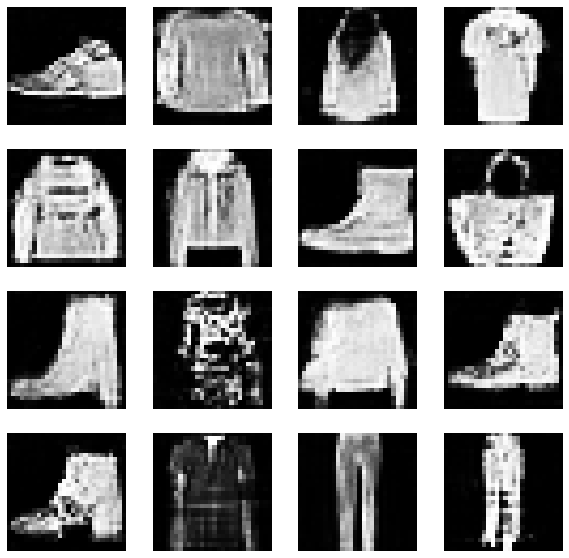

KeyboardInterrupt: ignored

In [0]:
 for epoch in range(EPOCHS):
    for bno, batch in enumerate(train_dataset):
        for _ in range(3):
            train_d(batch)
            d_loss = train_d(batch)
            disc_metric(d_loss)

        g_loss = train_g(len(batch))
        train_g(len(batch))
        gen_metric(g_loss)

        if bno%200==0:            
            print(f"Epcoh: {epoch}  batch: {bno} g_loss: {gen_metric.result():.3f}, d_loss: {disc_metric.result():.3f}")
            generate_and_save_images(g_model, bno + 1, noise_seed)
            clear_output(wait=False)
            
    checkpoint.save(file_prefix = checkpoint_prefix)
    gen_metric.reset_states()
    disc_metric.reset_states()